# Uber Marketplace City X Challenge

## Goals
Choose one:
<ol>
<li>Investigate whether Drivers are adequately notified about the city's demand in certain geographic areas at certain times. Present a strategy to address the challenge.
<li>Investigate the financial effectiveness of rider discount promotions. Present a strategy to identify current issues and improve the cost effectiveness of the rider promotions.
</ol>

## Deliverables

<ol>
<li>An educated, data-driven view on the potential issue
<li>A A/B test design to evalue a hypothesis or test a solution
<li>Recommended next steps and other factors to consider
</ol>

## Evaluation criteria

<ul>
<li>data cleaning, aggregation, and analysis
<li>identification of key patterns and trends
<li>strong and relevant experiment design
<li>recommendations including actionable next steps
<li>acknowledgement of other factors or considerations
</ul>

# TODO List

<ul>
<li>Calculate by-hour statistics for each of the four geos to add to city table
<li>Look at requests vs trips vs. hour by geo
<li>Look into the gap between requests and trips by trip status: rider_canceled vs. unfulfilled
<li>Look into why riders canceled: did they eventually successfully book a trip right after canceling, or is there a correlation between wait time and cancelation rate?
<li>Group trips by driver_id and estimate the trip time by time between pickup and next request time, for times when demand is high (completed trips < trips requested)
</ul>

## Odd Stuff

<ul>
<li>Trip ID 94a1-82d8: there four such trips (trips.index.value_counts())
<li>riders.describe() shows the maximum lifetime payments as $139k and over 16k trips. who could do that many trips in a lifetime?
<li>similar situation with the driver info
<li>missing est. time to arrival in some 2501 rider trips (about 10% of the total number of trips)
</ul>

In [1]:
import pandas as pd
import math
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
d_trips = pd.read_html("driver_trips.html", header=1, index_col='trip_id')[0] 

In [3]:
r_trips = pd.read_html("rider_trips.html", header=1, index_col='trip_id')[0]

In [4]:
city = pd.read_html("city_metrics.html", header=1, index_col='timestamp')[0]
drivers = pd.read_html("driver_data.html", header=1, index_col='driver_id')[0]
riders = pd.read_html("rider_data.html", header=1, index_col='rider_id')[0]

In [5]:
d_trips.drop(columns="1", inplace=True)
r_trips.drop(columns="1", inplace=True)
city.drop(columns="1", inplace=True)
drivers.drop(columns="1", inplace=True)
riders.drop(columns="1", inplace=True)

In [6]:
city.head()

,requests,trips,supply_hours,mean_surge_multipler
timestamp,,,,
4/9/12 12:00 AM,42,35,19.5,1.08
4/9/12 1:00 AM,19,15,11.5,1.00
4/9/12 2:00 AM,17,14,11.1,1.01
4/9/12 3:00 AM,7,5,3.7,1.03
4/9/12 4:00 AM,11,8,4.5,1.28


In [7]:
drivers.head()

,first_completed_trip,lifetime_rating,lifetime_fares,lifetime_completed_trips
driver_id,,,,
48dc-c2db,11/18/2010,4.82,8038.10,877
49aa-b176,12/29/2011,4.79,9428.02,967
4332-47bc,8/13/2010,4.92,13578.02,1719
4004-efca,2/12/2012,4.41,2020.95,172
4efa-33c0,4/28/2011,4.61,15984.75,1755


In [8]:
riders.head()

,first_completed_trip,lifetime_trips,first_trip_city_id,lifetime_payments
rider_id,,,,
040b-9e6e,2/28/2009,112.0,1020,3106.19
75cc-bc9e,4/21/2011,216.0,1020,1698.55
7b3b-5562,3/25/2010,188.0,1024,2101.36
a251-1bd5,9/8/2009,60.0,1032,683.39
1276-3268,11/5/2011,376.0,1032,2895.98


In [9]:
d_trips.head()

,driver_id,trip_status,actual_time_to_arrival,request_time,surge_multiplier,driver payout,start_geo,end_geo
trip_id,,,,,,,,
b3cb-b9bf,4649-2f0a,completed,3.52,4/9/12 6:12,1.0,4.24,Allen Abby,Chelsea Court
8569-0fbf,4003-e2e7,completed,2.63,5/6/12 5:44,2.0,8.24,Blair Bend,Chelsea Court
86f2-e4cc,44af-7b74,completed,1.33,4/25/12 11:28,1.0,6.20,Chelsea Court,Blair Bend
aef6-924e,4909-aa90,completed,1.70,4/27/12 21:34,1.0,8.19,Chelsea Court,Daisy Drive
921a-11d3,4e79-a40f,completed,NaN,4/30/12 16:44,1.0,11.81,Daisy Drive,Daisy Drive


In [10]:
r_trips.head()

,rider_id,trip_status,estimated_time_to_arrival,request_time,surge_multiplier,trip_price_pre_discount,rider_payment,start_geo,end_geo
trip_id,,,,,,,,,
b3cb-b9bf,5ba9-cd29,completed,4.48,4/9/12 6:12,1.0,5.296,5.296,Allen Abby,Chelsea Court
8569-0fbf,b8ed-f739,completed,4.68,5/6/12 5:44,2.0,10.304,10.304,Blair Bend,Chelsea Court
86f2-e4cc,a12d-275f,completed,1.98,4/25/12 11:28,1.0,7.744,7.744,Chelsea Court,Blair Bend
aef6-924e,14af-2a91,completed,2.75,4/27/12 21:34,1.0,10.232,10.232,Chelsea Court,Daisy Drive
921a-11d3,a0b5-fbfc,completed,NaN,4/30/12 16:44,1.0,14.760,14.760,Daisy Drive,Daisy Drive


## City Demand and Driver Positioning

The city GM observes disproportionate levels of surge pricing and higher ETAs in CC - sometimes 1-2 minutes higher than the city average - during rush hour. Also notes trip growth has been inconsistent in April and May. Question: could "fixing" CC rush hour help improve rider growth?

Some possible indicators of non-optimal driver positioning could include:
<ul>
<li>surge multiplier disparity: key indicator of poor driver positioning. If surge is 1 or low in one geo and very high in another, drivers could be more optimally positioned. 
<li>fraction of rider cancellations: how does cancellation rate depend on wait time? Does it affect newer users more than established users
<li>high estimated_times_to_arrival: could indicate poor positioning, but also could be caused by traffic congestion
<li>fraction of trip requests unfulfilled: indicates lack of overall supply. Here, again, looking for disparities between regions would be more indicative of poor positioning, but statistics for unfulfilled trips could be limited
</ul>

In [11]:
# Join the driver trips and rider trips tables on trip_id
trips = r_trips.join(d_trips, how='outer', lsuffix='_d', rsuffix='_r')

In [12]:
dup_columns = [ c_name.replace("_r", "") for c_name in trips.columns if "_r" in c_name ]

In [13]:
for c in dup_columns:
    r_col = c + "_r"
    d_col = c + "_d"
    trips[c] = trips[r_col].where( ~trips[r_col].isnull(), trips[d_col] )
    trips = trips.drop(columns=[r_col, d_col])

In [14]:
trips.head()

,rider_id,estimated_time_to_arrival,trip_price_pre_discount,rider_payment,driver_id,actual_time_to_arrival,driver payout,trip_status,request_time,surge_multiplier,start_geo,end_geo
trip_id,,,,,,,,,,,,
8000-41de,fa46-a452,NaN,0.000,0.0000,4e79-a40f,NaN,0.00,unfulfilled,4/21/12 3:18,1.0,Chelsea Court,Chelsea Court
8000-50ca,991c-b9bb,3.50,6.104,5.4936,49c5-1b68,2.55,4.88,completed,4/23/12 12:17,1.2,Chelsea Court,Chelsea Court
8000-6095,be95-fe1e,6.73,6.696,6.6960,401a-3f3a,5.25,5.36,completed,4/20/12 9:58,1.0,Chelsea Court,Blair Bend
8000-6624,05f9-5087,0.93,6.368,6.3680,443a-6a1b,0.83,5.09,completed,4/19/12 8:40,1.0,Chelsea Court,Chelsea Court
8001-3911,317c-651d,0.70,6.504,6.5040,45a5-92ef,0.27,5.20,completed,5/6/12 21:51,1.3,Chelsea Court,Chelsea Court


In [15]:
trips = trips.drop('94a1-82d8', axis=0)

In [16]:
trips['request_time'] = pd.to_datetime(trips['request_time'])

In [17]:
trips['dow'] = trips.request_time.dt.day_name()
trips['date'] = trips.request_time.dt.date
trips['hour'] = trips.request_time.dt.hour

In [20]:
trips_by_hour_means = trips.groupby(['date', 'hour']).mean()
trips_by_hour_counts = trips.groupby(['date', 'hour']).count()
trips_by_hour_status = trips.groupby(['date', 'hour', 'trip_status']).count()

In [256]:
trips.head()

,rider_id,estimated_time_to_arrival,trip_price_pre_discount,rider_payment,driver_id,actual_time_to_arrival,driver payout,trip_status,request_time,surge_multiplier,start_geo,end_geo,dow,hour,date,is_rush_hour
trip_id,,,,,,,,,,,,,,,,
8000-41de,fa46-a452,NaN,0.000,0.0000,4e79-a40f,NaN,0.00,unfulfilled,2012-04-21 03:18:00,1.0,Chelsea Court,Chelsea Court,Saturday,3,2012-04-21,False
8000-50ca,991c-b9bb,3.50,6.104,5.4936,49c5-1b68,2.55,4.88,completed,2012-04-23 12:17:00,1.2,Chelsea Court,Chelsea Court,Monday,12,2012-04-23,False
8000-6095,be95-fe1e,6.73,6.696,6.6960,401a-3f3a,5.25,5.36,completed,2012-04-20 09:58:00,1.0,Chelsea Court,Blair Bend,Friday,9,2012-04-20,False
8000-6624,05f9-5087,0.93,6.368,6.3680,443a-6a1b,0.83,5.09,completed,2012-04-19 08:40:00,1.0,Chelsea Court,Chelsea Court,Thursday,8,2012-04-19,False
8001-3911,317c-651d,0.70,6.504,6.5040,45a5-92ef,0.27,5.20,completed,2012-05-06 21:51:00,1.3,Chelsea Court,Chelsea Court,Sunday,21,2012-05-06,False


## Exploring the city info table

In [110]:
city['datetime'] = pd.to_datetime(city.index)

In [119]:
city.set_index('datetime', drop=True, inplace=True)

In [180]:
city = city.rename(columns={ 'mean_surge_multipler' : 'mean_surge_multiplier' })

In [181]:
city['dow'] = city.index.day_name()

In [182]:
city['hour'] = city.index.hour

In [183]:
city['trips_per_supply_hour'] = city['trips']/city['supply_hours']

In [184]:
city.describe()

,requests,trips,supply_hours,mean_surge_multiplier,hour,trips_per_supply_hour
count,672.000000,672.000000,672.000000,672.000000,672.000000,671.000000
mean,115.556548,98.119048,48.387798,1.110461,11.500000,1.944071
std,72.231308,60.410993,27.730596,0.123787,6.927343,0.265146
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.176471
25%,48.000000,41.000000,21.825000,1.020000,5.750000,1.780463
50%,117.000000,101.500000,51.900000,1.070000,11.500000,1.927570
75%,162.000000,137.000000,68.025000,1.170000,17.250000,2.133741
max,350.000000,291.000000,120.400000,2.160000,23.000000,2.558747


In [194]:
city['trips_per_request'] = city['trips']/city['requests']                     

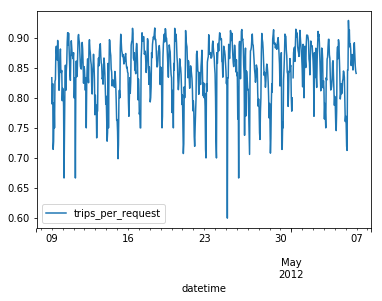

In [195]:
city.plot(y='trips_per_request')

In [ ]:
# Difference between trips and requests, as percentage total trips sfsfffffasfadarequests
trip_deficit = (city['requests'] - city['trips'])/city['requests']             

In [ ]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' ]

In [186]:
city_weekdays = city.loc[ city['dow'].isin( weekdays ) ]

In [187]:
weekday_by_hour = city_weekdays.groupby( city_weekdays['hour'] ).mean()

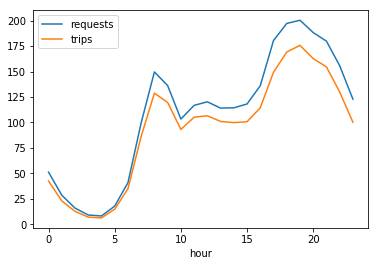

In [188]:
weekday_by_hour.plot(y=['requests', 'trips'])

Morning weekday rush hour: 8-9

Evening weekday rush hour: 17-20

In [257]:
# Let's add a rush_hour flag to the trips table. 
trips['hour'] = trips.request_time.dt.hour

In [258]:
rush_hours = [ 7, 8, 17, 18, 19, 20 ] 
trips['is_rush_hour'] = ( trips.hour.isin(rush_hours)) & ( trips.dow.isin(weekdays) )

In [263]:
trips.groupby('hour').mean()

,estimated_time_to_arrival,trip_price_pre_discount,rider_payment,actual_time_to_arrival,driver payout,surge_multiplier,is_rush_hour
hour,,,,,,,
0,2.745841,6.654737,6.645900,2.212120,5.332353,1.067974,0.000000
1,2.924242,6.292009,6.281470,2.322167,5.045614,1.069604,0.000000
2,3.631846,7.667501,7.641982,2.852436,6.134608,1.410829,0.000000
3,3.833140,7.172484,7.165733,3.233788,5.764437,1.341480,0.000000
4,4.390190,7.648604,7.546332,3.660166,6.148199,1.343868,0.000000
5,4.046857,6.974011,6.928032,3.366386,5.627236,1.274011,0.000000
6,3.682750,7.621209,7.592815,3.101544,6.145176,1.207004,0.000000
7,2.964728,7.064279,7.040481,2.494567,5.668118,1.104270,0.871910
8,3.534471,7.713931,7.602675,2.997067,6.180345,1.295911,0.871234


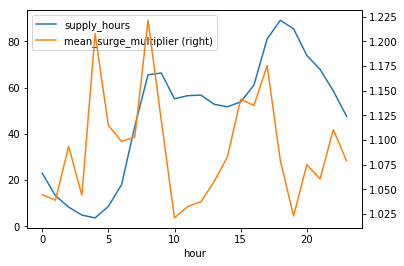

In [191]:
weekday_by_hour.plot(y=['supply_hours', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'])

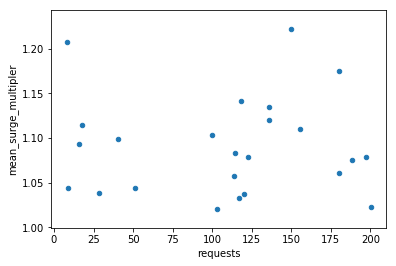

In [174]:
weekday_by_hour.plot(x='requests', y='mean_surge_multipler', kind='scatter')

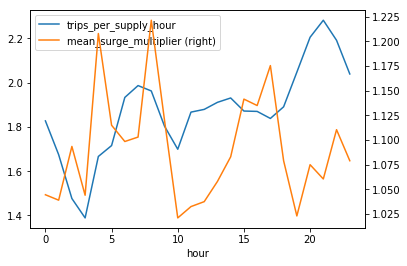

In [193]:
weekday_by_hour.plot( y=['trips_per_supply_hour', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'] )

In [196]:
trips.trip_status.value_counts()

completed         54138
rider_canceled     5777
failed               49
unfulfilled          34
Name: trip_status, dtype: int64

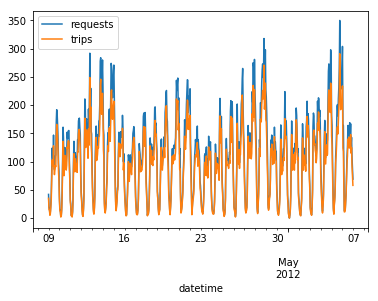

In [185]:
city.plot(y=['requests', 'trips'])

In [197]:
unfulfilled = trips.loc[ trips['trip_status'] == "unfulfilled" ]

In [200]:
start_geo_counts = trips['start_geo'].value_counts()/len(trips)
start_geo_counts

Chelsea Court    0.672706
Allen Abby       0.174889
Daisy Drive      0.079536
Blair Bend       0.072869
Name: start_geo, dtype: float64

In [201]:
unfulfilled['start_geo'].value_counts()/len(unfulfilled)

Chelsea Court    0.470588
Allen Abby       0.264706
Daisy Drive      0.147059
Blair Bend       0.117647
Name: start_geo, dtype: float64